Models are trained on different categories

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
import json
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay


# Prep data

In [2]:
pheme = pd.read_csv('datasets\pheme.csv')
pheme.rename(columns = {"Unnamed: 0":"entry"}, inplace=True)
pheme.head()

,entry,text,date,fav_count,retweet_count,username,account_date,followers,followings,tweet_count,protected,verified,no_hashtags,urls,event,target
0,0,break least dead injur gunman open fire offic ...,Wed Jan 07 11:06:08 +0000 2015,14,159,H_E_Samuel,Tue Oct 04 09:36:17 +0000 2011,1628,246,1901,False,False,0,[],charliehebdo-all-rnr-threads,True
1,1,franc peopl dead shoot hq satir weekli newspap...,Wed Jan 07 11:07:51 +0000 2015,38,486,euronews,Wed Mar 18 12:57:11 +0000 2009,129573,337,48440,False,True,1,[],charliehebdo-all-rnr-threads,True
2,2,ten kill shoot headquart french satir weekli c...,Wed Jan 07 11:08:09 +0000 2015,15,127,Channel4News,Mon Apr 28 14:29:37 +0000 2008,529882,3051,66682,False,True,1,[],charliehebdo-all-rnr-threads,True
3,3,break dead shoot headquart french satir weekli...,Wed Jan 07 11:09:50 +0000 2015,15,105,AlArabiya_Eng,Sat Feb 28 08:31:32 +0000 2009,499741,31,100466,False,True,2,[],charliehebdo-all-rnr-threads,True
4,4,reuter peopl shot dead headquart french satir ...,Wed Jan 07 11:11:16 +0000 2015,32,412,SkyNewsBreak,Wed Nov 04 11:25:45 +0000 2009,1377384,6,27228,False,True,1,[],charliehebdo-all-rnr-threads,True


In [3]:
twitter = pd.read_csv('datasets\\twitter.csv')
twitter.rename(columns = {"Unnamed: 0":"entry"}, inplace=True)

twitter.head()

,entry,text,verdict
0,0,ohio polic offic hospit eat shard glass sandwi...,False
1,1,one men want copi orlando shooter stop l liber...,False
2,2,missouri governor declar state emerg ahead gra...,False
3,3,iphon plu realli bend problem,False
4,4,paul walker die million cri million die human ...,True


In [4]:
def embed_dataset(dataset_text):
    nlp = spacy.load("spacy-twitter")
    encoded = np.array([nlp(text).vector for text in dataset_text])
    return encoded.tolist()

pheme['e_text'] = embed_dataset(pheme['text'])
twitter['e_text'] = embed_dataset(twitter['text'])


In [52]:
from sklearn.model_selection import train_test_split

# glove twitter
nlp = spacy.load("spacy-twitter")
X = np.array([nlp(text).vector for text in pheme['text']])

pheme['e_text'] = X.tolist()
pheme_train = pheme.drop('target', axis=1)
#6/2/2 train/val/test
X_train, X_test, y_train, y_test = train_test_split(pheme_train, pheme['target'], test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
X_train_text = np.array([text for text in X_train['e_text']])
X_test_text = np.array([text for text in X_test['e_text']])

# Train models  

SVMs trained on each category

In [5]:
from hpsklearn import HyperoptEstimator
from hpsklearn import svc 

def optimize_model(model_name, X_train, y_train):
    mod = HyperoptEstimator(classifier=svc(name=model_name, probability=True, random_state=42),
                            preprocessing=[],
                            max_evals=50,
                            trial_timeout=120,
                            verbose=False)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

100%|██████████| 50/50 [00:02<00:00,  2.96s/trial, best loss: 0.5592515592515592]
{'learner': SVC(C=0.6703441848573797, coef0=0.7548363030338627,
    decision_function_shape='ovo', degree=5, kernel='poly', probability=True,
    random_state=42, shrinking=False, tol=0.0004165728031024247), 'preprocs': (), 'ex_preprocs': ()}
Accuracy: 69.29 %
F1: 66.44 %


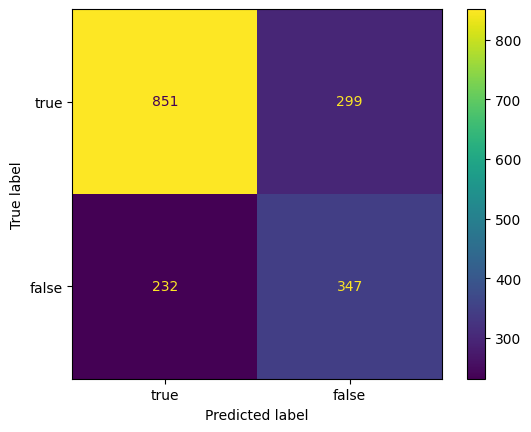

In [6]:
from hpsklearn import svc 
from sklearn.model_selection import train_test_split

# Make baseline trained on all data
X_train = pheme.drop('target', axis=1)
y_train = pheme['target']
X_train_text = np.array([text for text in X_train['e_text']])
X_test = twitter.drop('verdict', axis=1)
X_test_text = np.array([text for text in X_test['e_text']])
y_test = twitter['verdict']
baseline = optimize_model("Baseline", X_train_text, y_train)
evaluate_model(baseline, X_test_text, y_test)

100%|██████████| 50/50 [00:04<00:00,  4.75s/trial, best loss: 0.18441558441558437]
{'learner': SVC(C=1.7471913774684704, coef0=0.4669858603118654,
    decision_function_shape='ovo', degree=4, probability=True, random_state=42,
    shrinking=False, tol=0.005570264641213312), 'preprocs': (), 'ex_preprocs': ()}
Accuracy: 81.08 %
F1: 80.95 %


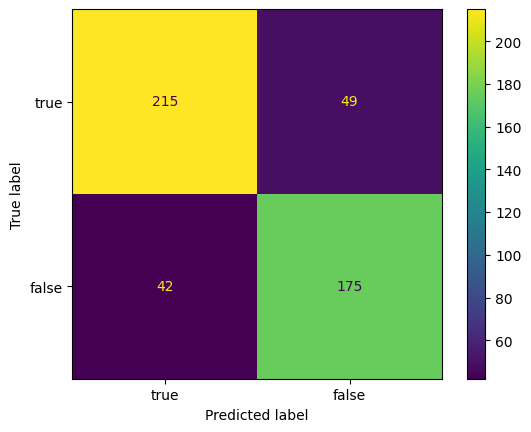

In [ ]:
#ONLY PHEME
from hpsklearn import svc 
from sklearn.model_selection import train_test_split

# Make baseline trained on all data
pheme['e_text'] = X.tolist()
pheme_train = pheme.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(pheme, pheme['target'], test_size = 0.2, random_state = 42)
X_train_text = np.array([text for text in X_train['e_text']])
X_test_text = np.array([text for text in X_test['e_text']])
baseline = optimize_model("Baseline", X_train_text, y_train)
evaluate_model(baseline, X_test_text, y_test)

In [6]:
file_name = "pheme_cats\pheme_categories_organised.json"
f = open(file_name)
data = json.load(f)

In [7]:
#Multiple datasets
confidence_threshold = 0.0
size_threshold = 100
train_set = pheme

trained_svms = {}
trained_cats = []
for key in data.keys():
    svm_name = f"svm_{key}"
    cat_entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
    if len(cat_entries) < size_threshold:
        print(f"Skipped category: {key} due to low numbers")
        continue
    all_in_cat = train_set.filter(axis=0, items=cat_entries)
    X_train = all_in_cat.drop('target', axis=1)
    y_train = all_in_cat['target']
    print(np.unique(all_in_cat["target"]))
    if (len(np.unique(all_in_cat["target"])) <= 1):
        print(f"Skipped category: {key} due to class issues")
        continue
    X_train_text = np.array([text for text in X_train['e_text']])
    try:
        svm_name = optimize_model(svm_name, X_train_text, y_train)
    except:
        print(f"error training {key} svm, skipping")
        continue
    trained_svms[key] = svm_name
    trained_cats.append(key)
    print(f"Created SVM trained in category: {key}")

[False  True]
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:01<00:00,  1.65s/trial, best loss: 0.2222222222222222]
{'learner': SVC(C=1.094741360893688, coef0=0.7068246109862362, degree=4, gamma='auto',
    kernel='poly', probability=True, random_state=42,
    tol=3.786936226888929e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Law & Government
[False  True]
100%|██████████| 50/50 [00:01<00:00,  1.84s/trial, best loss: 0.21327014218009477]
{'learner': SVC(C=1.3959080932629915, coef0=0.3366821895317601,
    decision_function_shape='ovo', degree=2, gamma='auto', kernel='sigmoid',
    probability=True, random_state=42, tol=0.00018567467362610697), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
[False  True]
100%|██████████| 50/50 [00:01<00:00,  1.64s/trial, best loss: 0.19047619047619047]
{'learner': SVC(C=0.8866852932377355, coef0=0.5679424303555841, degree=1, gamma='auto',
    kernel='linear', probability=True, random_state=42, shrinking=False,
    tol=0.0009468740302

In [20]:
file_name = "pheme_cats\\pheme_categories_organised.json"
f = open(file_name)
data = json.load(f)

confidence_threshold = 0.0
for key in data.keys():
    entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
    all_in_cat = pheme.filter(axis=0, items=entries)
    t = 0
    f=0
    for e in all_in_cat["target"]:
        if e:
            t += 1
        else:
            f += 1
    print(key, len(entries), len(all_in_cat))
    #print(t, f)

Law & Government 540 540
News 1053 1053
Food & Drink 103 103
Sensitive Subjects/Violence & Abuse 478 478
Sensitive Subjects/Death & Tragedy 529 529
Sensitive Subjects/War & Conflict 396 396
Online Communities 420 420
Sensitive Subjects/Other 337 337
Internet & Telecom 28 28
Computers & Electronics 41 41
People & Society 437 437
Health 92 92
Arts & Entertainment 585 585
Adult 20 20
Business & Industrial 62 62
Sensitive Subjects/Self-Harm 21 21
Shopping 80 80
Beauty & Fitness 14 14
Books & Literature 14 14
Reference 47 47
Autos & Vehicles 22 22
Pets & Animals 43 43
Science 41 41
Jobs & Education 8 8
Finance 29 29
Sensitive Subjects/Accidents & Disasters 97 97
Travel & Transportation 49 49
Games 15 15
Hobbies & Leisure 27 27
Sports 28 28
Home & Garden 13 13
Sensitive Subjects/Firearms & Weapons 22 22
Sensitive Subjects/Recreational Drugs 13 13


In [ ]:
# ONLY PHEME
from sklearn.model_selection import train_test_split

confidence_threshold = 0.2
size_threshold = 20
pheme['e_text'] = X.tolist()
X_test = pd.DataFrame(columns = pheme.columns)
y_test = []

trained_svms = {}
trained_cats = []
for key in data.keys():
    svm_name = f"svm_{key}"
    cat_entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
    if len(cat_entries) < size_threshold:
        print(f"Skipped category: {key} due to low numbers")
        continue
    all_in_cat = pheme.filter(axis=0, items=cat_entries)
    X_train, X_te, y_train, y_te = train_test_split(all_in_cat, all_in_cat['target'], test_size = 0.2, random_state = 42)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
    X_test = pd.concat([X_test, X_te])
    for target in y_te:
        y_test.append(target)
    X_train_text = np.array([text for text in X_train['e_text']])
    svm_name = optimize_model(svm_name, X_train_text, y_train)
    trained_svms[key] = svm_name
    trained_cats.append(key)
    print(f"Created SVM trained in category: {key}")

NameError: name 'X' is not defined

In [8]:
def predict_points(points):
    f = open("twitter_categories.json")
    test_data = json.load(f)
    f.close()
    final_predictions = []
    final_predictions2 = []
    for i in tqdm(range(len(points))):
        point = points.iloc[i]
        point_text = np.array([text for text in point['e_text']])
        topics = test_data[str(point["entry"])]
        topic_weights = {}
        for topic in topics:
            main_topic = topic.split("/")[1]
            if topics[topic] < confidence_threshold or main_topic not in trained_cats:
                continue
            if main_topic in topic_weights:
                topic_weights[main_topic] += topics[topic]
            else:
                topic_weights[main_topic] = topics[topic]
        #print(topic_weights) 
        model_predictions = []
        for topic in topic_weights:
            model = trained_svms[topic]
            pred = model.predict(point_text.reshape(1,-1))
            #model_predictions.append((pred[0], topic_weights[topic]))
            model_predictions.append((pred[0], 1))
        #print(model_predictions)
        true_mark = 0
        false_mark = 0
        for pred, score in model_predictions:    
            if pred == True:
                true_mark += score
            else:
                false_mark += score
        #print(mark)
        if (true_mark > false_mark):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
        max = 0
        final_pred = True
        for pred, score in model_predictions:
            if score > max:
                final_pred = pred
        final_predictions2.append(final_pred)
    return final_predictions, final_predictions2
             
def check_score(test, pred):
    acc = accuracy_score(test, pred)
    print("Accuracy:", float("{0:.2f}".format(acc*100)), "%")
    f1 = f1_score(test, pred, average="macro")
    print("F1:", float("{0:.2f}".format(f1*100)), "%")
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

100%|██████████| 1729/1729 [00:00<00:00, 2083.96it/s]


Accuracy: 66.63 %
F1: 44.48 %


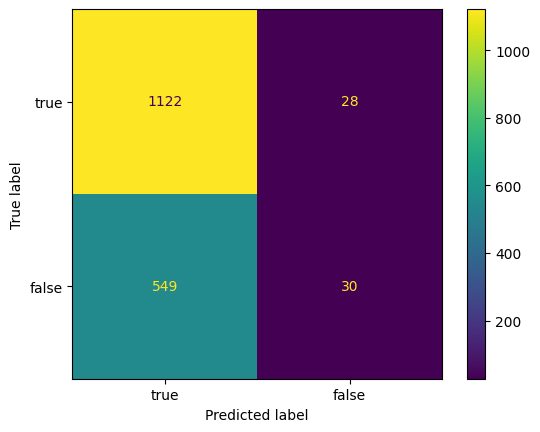

Accuracy: 65.07 %
F1: 48.58 %


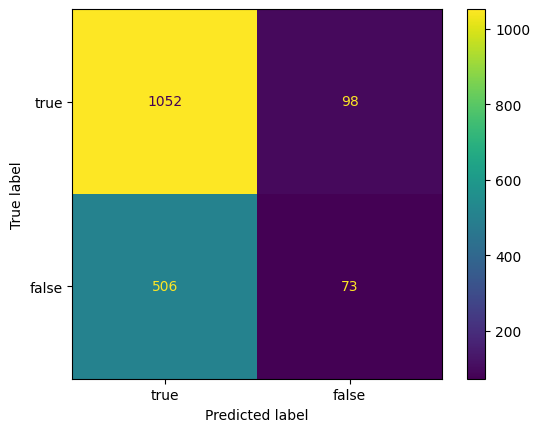

In [9]:
X_test = twitter.drop('verdict', axis=1)
y_test = twitter['verdict']
f1, f2 = predict_points(X_test)
#print(f)
#y_test = y_test.drop([385])
check_score(y_test, f1)
check_score(y_test, f2)

  0%|          | 0/1117 [00:00<?, ?it/s]

100%|██████████| 1117/1117 [00:00<00:00, 2024.69it/s]


Accuracy: 67.95 %
F1: 46.73 %


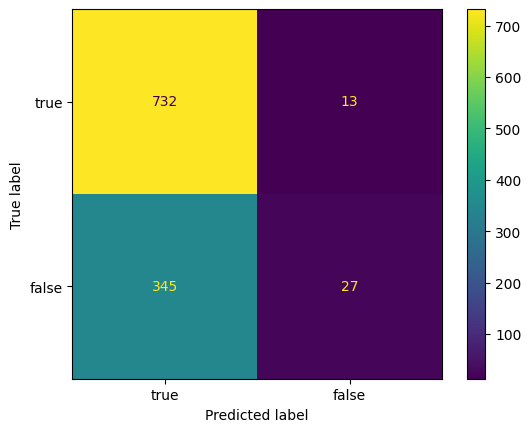

Accuracy: 66.61 %
F1: 51.74 %


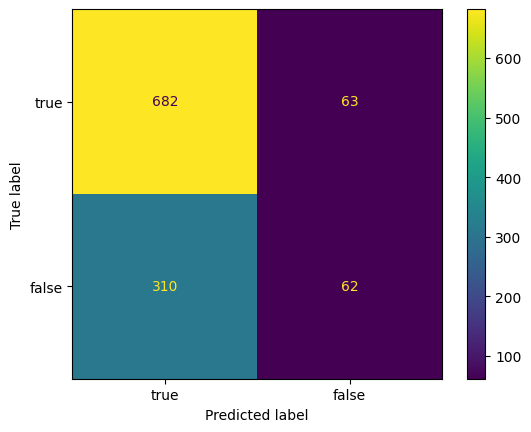

In [12]:
X_test_15 = twitter.iloc[:1117].drop('verdict', axis=1)
y_test_15 = twitter.iloc[:1117]['verdict']
f1, f2 = predict_points(X_test_15)
check_score(y_test_15, f1)
check_score(y_test_15, f2)

  0%|          | 0/612 [00:00<?, ?it/s]

100%|██████████| 612/612 [00:00<00:00, 2018.55it/s]


Accuracy: 64.22 %
F1: 40.37 %


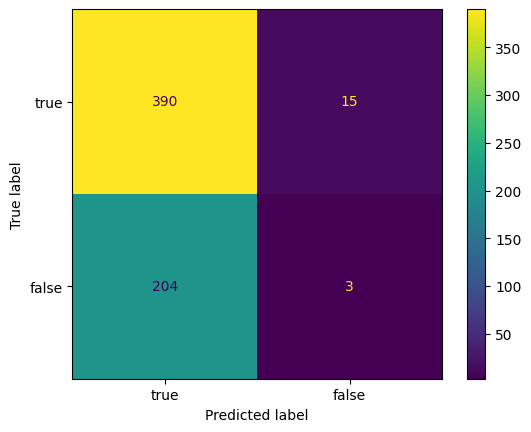

Accuracy: 62.25 %
F1: 42.45 %


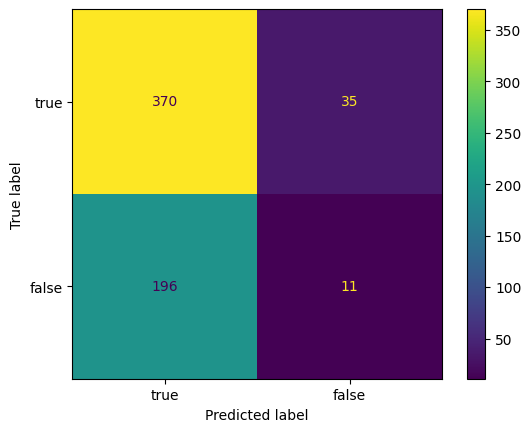

In [13]:
X_test_16 = twitter.iloc[1117:].drop('verdict', axis=1)
y_test_16 = twitter.iloc[1117:]['verdict']
f1, f2 = predict_points(X_test_16)
check_score(y_test_16, f1)
check_score(y_test_16, f2)